### The University of Melbourne, School of Computing and Information Systems
# COMP90086 Computer Vision, 2023 Semester 2

## Assignment 2

**Student Name:**    `TANZID SULTAN`

**Student ID:**     `1430660`

## This iPython notebook is a template which you should use for your Assignment 2 submission. This file should be submitted at the **Assignment 2: Code** link on the LMS.

In addition to this file, you should submit a written report explaining your results at the **Assignment 2: Report** link on the LMS. Please see the assignment specification for details on what must be included in the report for each question.

*Adding proper comments to your code is MANDATORY.*

### 1. CNN training

The following code section will load the dataset from a folder that you specify. You may change the batch sizes and add additional data augmentation steps here if you wish.

In [1]:
# library imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model

# make sure GPU is available
print(tf.config.list_physical_devices('GPU'))


2023-09-09 14:14:58.264581: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-09 14:14:58.298830: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-09 14:14:58.822326: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-09-09 14:15:00.061963: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-09 14:15:00.106754: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-09 14:15:00.107187: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


#### Below, we instantiate the ImageDataGenerators for the training, validation and test datasets. We also perform image augmentation for training data set (horizontal and vertical  translations, zooming, horizontal flipping and rotations).

In [2]:

data_dir = 'scene32' # SPECIFY YOUR PATH TO THE DATASET
batch_size = 80

# Data generator for training
# Additional data augmentation may be added here if desired
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,                    # flip horizontally 
    rotation_range=10,                       # random rotations 
    width_shift_range=0.3,                   # random horizontal translations 
    height_shift_range=0.3,                  # random vertical translations 
    zoom_range=0.1,                          # random zooming
    fill_mode= 'nearest' 
    )

# Data generator for test
# DO NOT USE DATA AUGMENTATION WITH TEST SET
test_datagen = ImageDataGenerator(
    rescale=1./255)

# Generate training data from 'train' directory
train_data = train_datagen.flow_from_directory(
        data_dir+'/train',
        target_size=(32,32),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=1)

# Generate vaildation data from 'valid' directory
val_data = test_datagen.flow_from_directory(
        data_dir+'/valid',
        target_size=(32,32),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=1)

# Generate test data from 'test' directory
test_data = test_datagen.flow_from_directory(
        data_dir+'/test',
        target_size=(32,32),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

# Output list of class names
class_names_and_indices = train_data.class_indices
print(class_names_and_indices)

# Note: To train a model with the dataset loaded above, pass the train and val
# datasets to the fit() function, like so:
# myModel.fit(train_data, validation_data=val_data, ...)

Found 1440 images belonging to 8 classes.
Found 320 images belonging to 8 classes.
Found 320 images belonging to 8 classes.
{'coast': 0, 'forest': 1, 'highway': 2, 'insidecity': 3, 'mountain': 4, 'opencountry': 5, 'street': 6, 'tallbuilding': 7}


#### We now build a CNN model with two convolutional layers followed by two dense layers (using parameters given in the assignment specifications)

In [6]:
# initial learning rate
lr = 0.001 
# scehduler for exponentially decaying learning rate
lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(lr, decay_steps=300, decay_rate=0.8)
# weight initializers
initializer1 = tf.keras.initializers.GlorotNormal(seed=1)
initializer2 = tf.keras.initializers.GlorotNormal(seed=2)
initializer3 = tf.keras.initializers.GlorotNormal(seed=3)
initializer4 = tf.keras.initializers.GlorotNormal(seed=4)

# build the model
cnn1 = keras.Sequential(
    [
        layers.Input((32,32,3)),                                                                         # input image shape is 32x32x3  
        layers.Conv2D(16, (3,3), padding='valid', activation='relu', kernel_initializer=initializer1),
        layers.BatchNormalization(),                                                                     # batch normalization to speed up training
        layers.Conv2D(16, (3,3), padding='valid', activation='relu', kernel_initializer=initializer2),
        layers.BatchNormalization(),                                                                     # batch normalization to speed up training
        layers.MaxPooling2D((2,2), strides=(2,2), padding='valid'),
        layers.Flatten(), 
        layers.Dropout(0.2),                                                                               # unravel the 3d tensor from the previous layer output
        layers.Dense(64, activation='relu', kernel_initializer=initializer3),  
        layers.Dense(8, activation='softmax', kernel_initializer=initializer4)                           # output layer with 8 neurons, corresponding to the 8 categories
    ]
)


# configure the model
cnn1.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_scheduler), loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

# display model summary
cnn1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 16)        448       
                                                                 
 batch_normalization_2 (Batc  (None, 30, 30, 16)       64        
 hNormalization)                                                 
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 16)        2320      
                                                                 
 batch_normalization_3 (Batc  (None, 28, 28, 16)       64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                      

#### We now train the model for 150 epochs (we stop at 150 epochs because the optimizer converges within 100 epochs, as evident from the plateuing of the learning curves)

In [7]:
# train the model 
history_cnn1_aug = cnn1.fit(train_data, validation_data=val_data, epochs=150, verbose=0) 

2023-09-09 14:15:36.235685: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-09-09 14:15:37.815766: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


#### Visualizing the learning curves

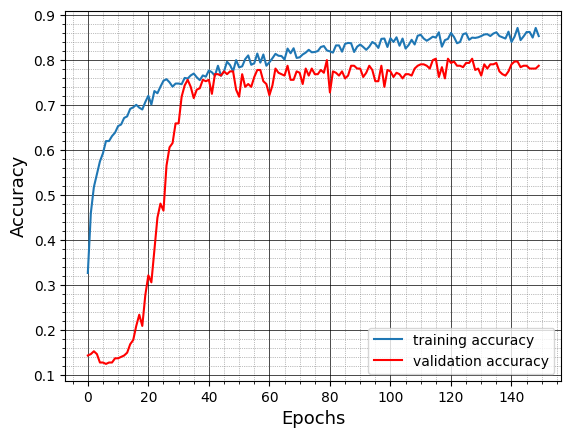

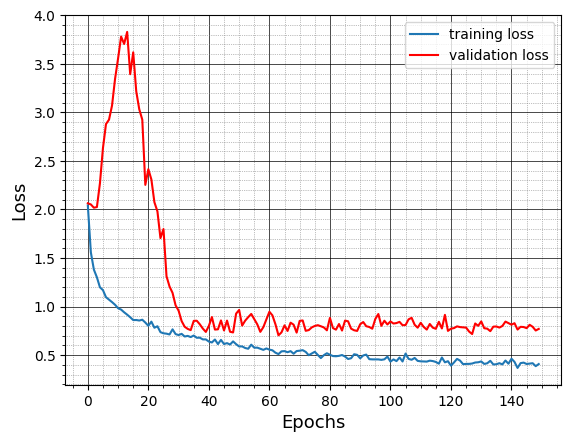

In [10]:
# plot some learning curves
def plot_graphs(training_history, metric):
    #fig = plt.figure(figsize=(5, 5))
    plt.plot(training_history.history[metric])
    plt.plot(training_history.history["val_"+metric], 'r')
    plt.xlabel("Epochs", fontsize=13)
    plt.ylabel(metric.capitalize(), fontsize=13)
    plt.minorticks_on()
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')

    plt.legend(["training "+metric, "validation "+metric])
    plt.show()

plot_graphs(history_cnn1_aug, "accuracy")
plot_graphs(history_cnn1_aug, "loss")


#### We now evaluate the model accuracy on the unseen test dataset.

In [11]:
test_results = cnn1.evaluate(test_data)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]*100}%')

4/4 [==============================] - 0s 9ms/step - loss: 0.7001 - accuracy: 0.8031
Test results - Loss: 0.7001458406448364 - Accuracy: 80.31250238418579%


2023-09-09 14:19:31.456009: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


##### Note: This training run produced a slightly higher test accuracy that the run which was used in the report.

### 2. Error anaylsis

#### In this section, we will evaluate the model's prediction accuracy for each class

#### It is also useful to plot a confusion matrix so that we can see if there are any obvious patterns in how the model misclassifies images from certain classes and identify if there are certain classes which are more difficult for the model to classify.

In [12]:
# dictionary for converting class index to name
class_names = {c_index : c_name for (c_name, c_index) in class_names_and_indices.items()}


# function for computing average test dasetset accuracy per class and for plotting confusion matrix
def class_average(model):
    # get the test images and class probabilities
    xs, ys = [], []
    n_batches = int(np.ceil(test_data.n/test_data.batch_size))
    for i in range(n_batches):
        x_batch, y_batch = next(test_data)
        xs.append(x_batch)
        ys.append(y_batch)
    x_test = np.concatenate(xs, axis=0)    
    y_test = np.concatenate(ys, axis=0)

    # convert class probabilities to class label
    labels = np.argmax(y_test, axis=1) 

    # compute predicted class probabilities and labels for test data
    y_preds = model.predict(x_test) 
    labels_preds = np.argmax(y_preds, axis=1) 

    # compute accuracy per class
    n_class = 8
    n_img_per_class = 40 
    n_correct_tot = 0
    for i in range(n_class):
        n_correct = np.sum(np.equal(labels_preds[i*n_img_per_class : (i+1)*n_img_per_class], labels[i*n_img_per_class : (i+1)*n_img_per_class]))
        n_correct_tot += n_correct
        print(f"Class: {class_names[i]}, Number of correct predictions: {n_correct}/{n_img_per_class}, Average Accuracy: {n_correct/n_img_per_class}")
        
    print(f"\nOverall classification accuracy for test data: {n_correct_tot/(n_class * n_img_per_class)}")


    # plot confusion matrix
    disp = ConfusionMatrixDisplay.from_predictions(labels, labels_preds, display_labels= class_names_and_indices.keys(), colorbar=False)
    fig = disp.figure_
    fig.set_figwidth(9)
    fig.set_figheight(9) 

    return x_test, labels, labels_preds

10/10 [==============================] - 0s 2ms/step
Class: coast, Number of correct predictions: 27/40, Average Accuracy: 0.675
Class: forest, Number of correct predictions: 35/40, Average Accuracy: 0.875
Class: highway, Number of correct predictions: 30/40, Average Accuracy: 0.75
Class: insidecity, Number of correct predictions: 38/40, Average Accuracy: 0.95
Class: mountain, Number of correct predictions: 35/40, Average Accuracy: 0.875
Class: opencountry, Number of correct predictions: 22/40, Average Accuracy: 0.55
Class: street, Number of correct predictions: 35/40, Average Accuracy: 0.875
Class: tallbuilding, Number of correct predictions: 35/40, Average Accuracy: 0.875

Overall classification accuracy for test data: 0.803125


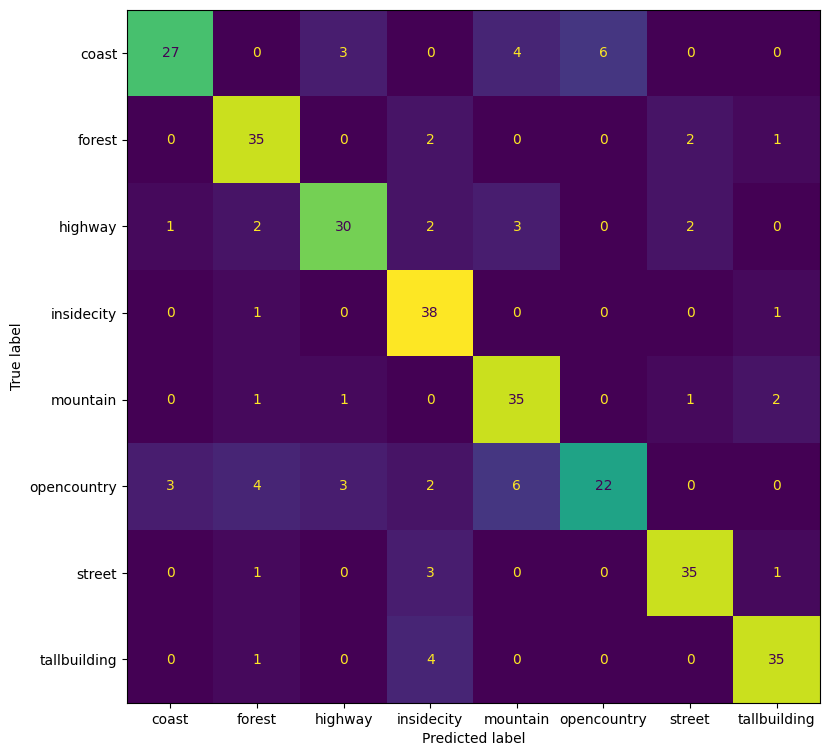

In [13]:
x_test, labels, labels_preds = class_average(cnn1)

#### From inspecting the confusion matrix, it looks like 'street', 'tallbuilding' and 'highway' images are frequently miscalssified as being 'insidecity', not too surprising as these classes share lots of similar features, e.g. asphalt/roads are present across all of these classes. 'Mountain' is mostly misclassified as either 'forest', 'insidecity' or 'tallbuilding'. 'opencountry' is the hardest to classify followed by 'coast'. Both of these classes share significantly similar features with many of the other classes, such as open skies and large expanses of land. 

#### Taking a closer look at some of the mis-calssified images

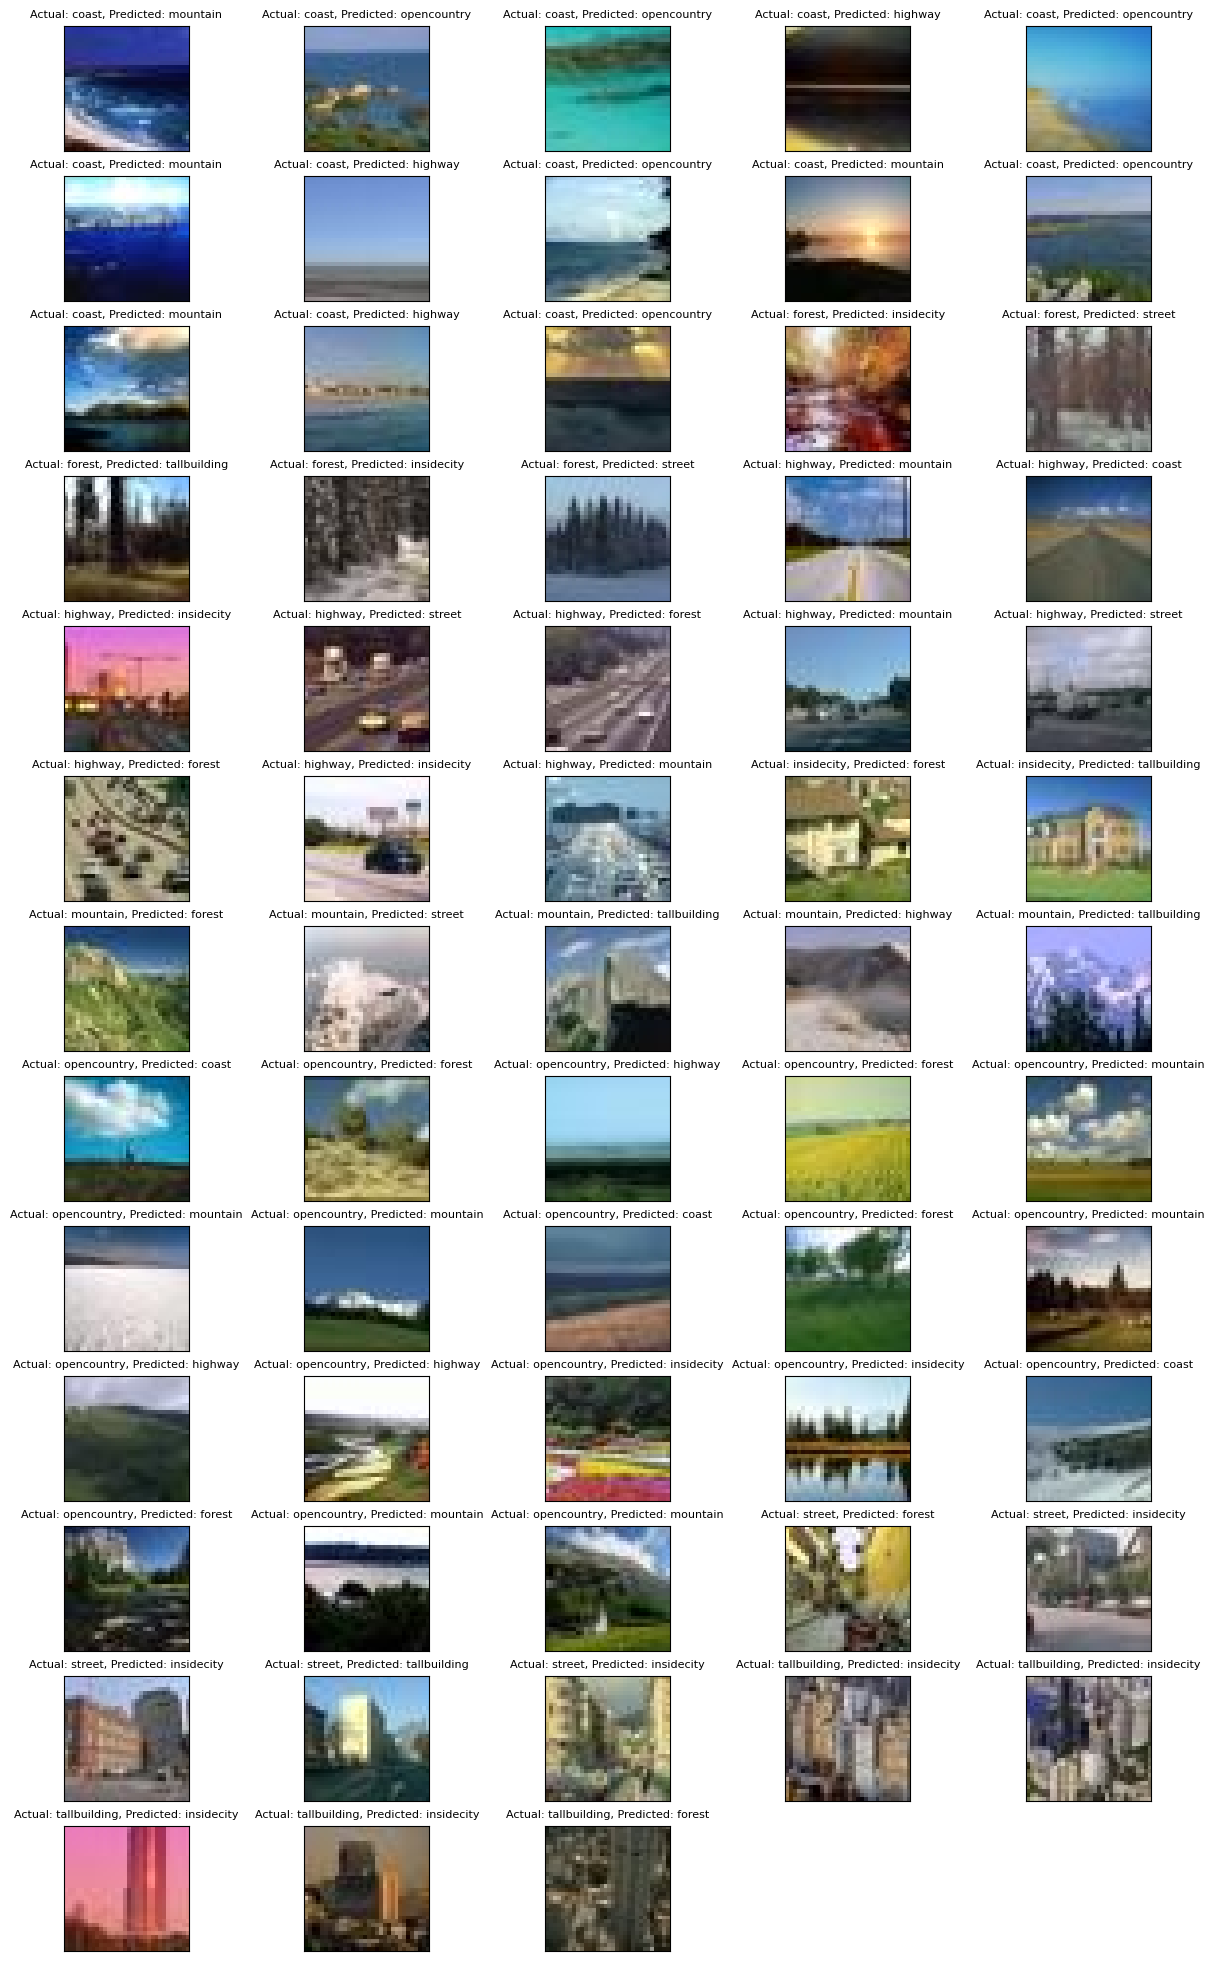

In [14]:
# plot misclassified images from each class
fig = plt.figure(figsize=(15, 25))

n_images = x_test.shape[0]
n_incorrect = n_images - np.sum(np.equal(labels_preds, labels))
ix = 1
for i in range(n_images):
    if(labels[i] != labels_preds[i]):
        ax = plt.subplot(int(np.ceil(n_incorrect/5)), 5, ix)
        plt.imshow(x_test[i])
        plt.title(f"Actual: {class_names[labels[i]]}, Predicted: {class_names[labels_preds[i]]}", fontsize=8)
        ax.set_xticks([])
        ax.set_yticks([])
        ix += 1

plt.show()        

### 3. Kernel engineering

#### In this section, we train a CNN Model with only one Conv layer with K x K filters for varying K. For each K, we repeat the training 3 times and keep the average test set accuracy for a smoother estimate.

#### For each K, we save the test accuracy, the convolutional layer and the filters in a list, which we use later to create visualizations of the filters and feature activation maps.

In [21]:
# list of filter sizes
kernel_sizes = [2,3,4,5,7,9,12,16,20,25,30]
training_epochs = 300
repeat_runs = 3

In [ ]:
# lists for saving test accuracy, conv layer and filters for each k
accuracies_k = []
conv_layer_k = []
filters_k = []

# train model for each different filter size
for k in kernel_sizes:

    print(f"k = {k}")

    test_acc = []
    
    # repeat training for each k three times to get smoother estimate of test accuracy 
    for j in range(repeat_runs):
        
        # initial learning rate
        lr = 0.001 
        # scehduler for exponentially decaying learning rate
        lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(lr, decay_steps=100, decay_rate=0.8)
        # weight initializers
        initializer1 = tf.keras.initializers.GlorotNormal(seed=1)
        initializer2 = tf.keras.initializers.GlorotNormal(seed=2)
        initializer3 = tf.keras.initializers.GlorotNormal(seed=3)

        # build the model
        cnn2 = keras.Sequential(
            [
                layers.Input((32,32,3)),                                                                         # input image shape is 32x32x3  
                layers.Conv2D(16, (k,k), padding='valid', activation='relu', kernel_initializer=initializer1),
                layers.BatchNormalization(),                                                                     # batch normalization to speed up training
                layers.MaxPooling2D((2,2), strides=(2,2), padding='valid'),
                layers.Flatten(), 
                #layers.Dropout(0.2),                                                                            # unravel the 3d tensor from the previous layer output
                layers.Dense(64, activation='relu', kernel_initializer=initializer2),  
                layers.Dense(8, activation='softmax', kernel_initializer=initializer3)                           # output layer with 8 neurons, corresponding to the 8 categories
            ]
        )


        # configure the model
        cnn2.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_scheduler), loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

        # display model summary
        #cnn2.summary()

        # train the model again, this time with augmented images
        history_cnn2 = cnn2.fit(train_data, validation_data=val_data, epochs=training_epochs, verbose=0) 

        # Evaluate model performance on the test data
        test_results = cnn2.evaluate(test_data)
        print(f'Test results - Loss: {test_results[0]} - Accuracy: {100*test_results[1]}%')

        test_acc.append(test_results[1])
        
        # plot learning curve
        # plot_graphs(history_cnn2, "accuracy")
        # plot_graphs(history_cnn2, "loss")
   
    # get filter weights
    f, _ = cnn2.layers[0].get_weights()
    # normalize the values to be in [0,1] for visualization purposes
    f_min , f_max = f.min(), f.max()
    f = (f-f_min) / (f_max- f_min)
    
    # get a copy of the conv layer
    conv_layer_k.append(cnn2.layers[0])
    filters_k.append(f)
    # keep average test accuracy 
    avg_test_accuracy = sum(test_acc)/len(test_acc)
    accuracies_k.append(avg_test_accuracy)
    print(f"Average test accuracy (k = {k}): {avg_test_accuracy} ")

#### Plot the test accuracy vs kernel size. Note that test accuracy decreases as filter size increases

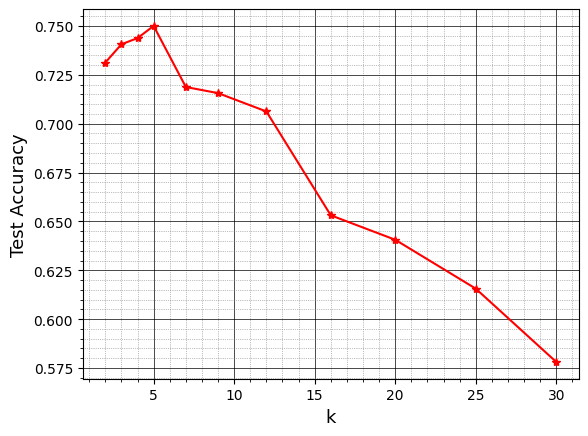

In [614]:
# plot the test acuuracy vs k
plt.plot(kernel_sizes, accuracies_k, 'r*-')
plt.xlabel("k", fontsize=13)
plt.ylabel("Test Accuracy", fontsize=13)
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.show()

#### We now visualize the filters learned by our model at a few different K. We shall also inspect the feature activation maps, i.e. output of the convolutional layer for a test image.

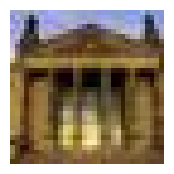

In [672]:
# load a test image from the training set
img = load_img(data_dir+'/train/insidecity/insidecity_a129035.jpg', target_size=(32, 32))

fig = plt.figure(figsize=(2, 2))
plt.imshow(img)
plt.axis('off')
plt.show()

# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = np.expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)

#### Visualize the learned filters and filtered test image for k = 2

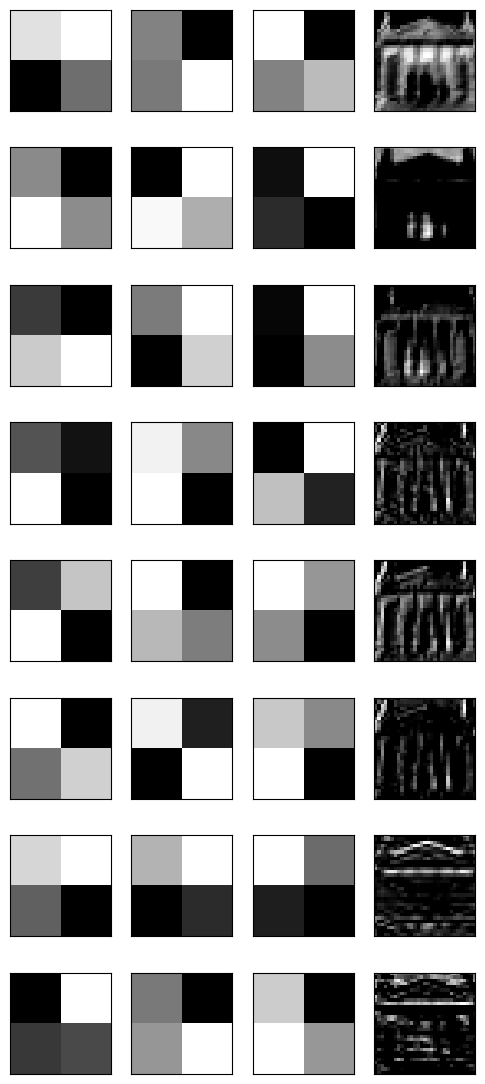

In [665]:
# get filters
filters = filters_k[0]

# get feature map for conv layer
feature_maps = conv_layer_k[0](img)

fig = plt.figure(figsize=(6, 14))
ix =  1

# display every other filter
for i in range(0,16,2):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(4):
        # subplot for 6 filters and 3 channels and activation map in grayscale
        # specify subplot and turn of axis
        ax = plt.subplot(8, 4, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        if j < 3:    
            # plot filter channel in grayscale
            plt.imshow(f[:, :, j], cmap='gray')
        else:
            # plot feature map in grayscale
            plt.imshow(feature_maps[0,:,:,i] , cmap='gray')

        ix += 1
# plot the filters
plt.show()

#### In this figure, we show 8 of the 16 learned filters. Each row shows a different filter, the first three columns are the three filter channels and the last column is the result of convolving the test image with the filter.

#### Visualize the learned filters and filtered test image for k = 5

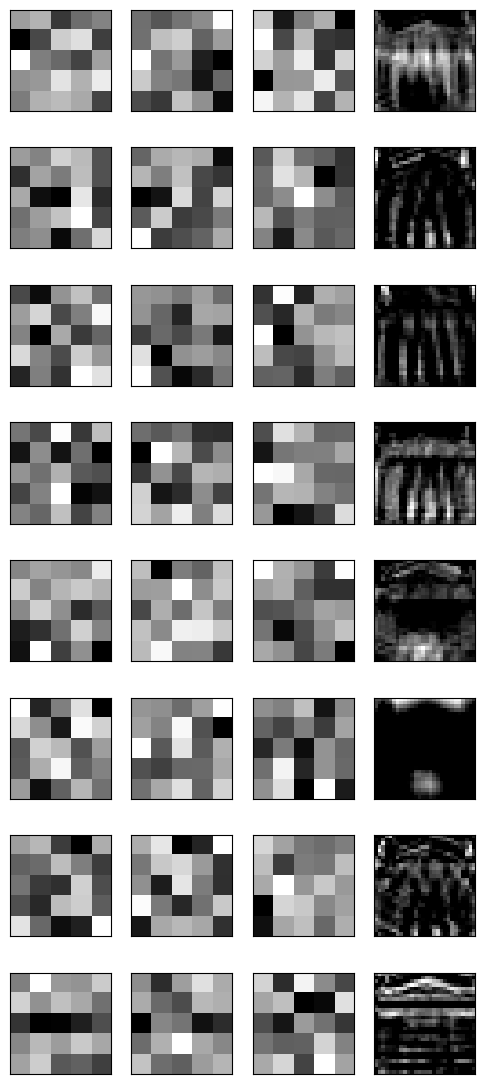

In [664]:
# get filters
filters = filters_k[3]

# get feature map for conv layer
feature_maps = conv_layer_k[3](img)

fig = plt.figure(figsize=(6, 14))
ix =  1

# display every other filter
for i in range(0,16,2):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(4):
        # subplot for 6 filters and 3 channels and activation map in grayscale
        # specify subplot and turn of axis
        ax = plt.subplot(8, 4, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        if j < 3:    
            # plot filter channel in grayscale
            plt.imshow(f[:, :, j], cmap='gray')
        else:
            # plot feature map in grayscale
            plt.imshow(feature_maps[0,:,:,i] , cmap='gray')

        ix += 1
# plot the filters
plt.show()

#### Visualize the learned filters and filtered test image for k = 12

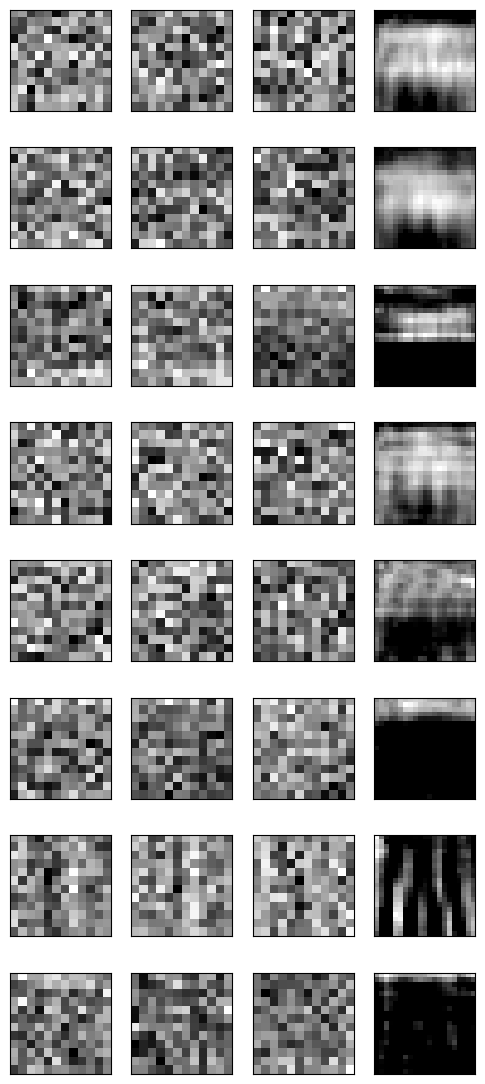

In [661]:
# get filters
filters = filters_k[6]

# get feature map for conv layer
feature_maps = conv_layer_k[6](img)

fig = plt.figure(figsize=(6, 14))
ix =  1

# display every other filter
for i in range(0,16,2):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(4):
        # subplot for 6 filters and 3 channels and activation map in grayscale
        # specify subplot and turn of axis
        ax = plt.subplot(8, 4, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        if j < 3:    
            # plot filter channel in grayscale
            plt.imshow(f[:, :, j], cmap='gray')
        else:
            # plot feature map in grayscale
            plt.imshow(feature_maps[0,:,:,i] , cmap='gray')

        ix += 1
# plot the filters
plt.show()

#### Visualize the learned filters and filtered test image for k = 25

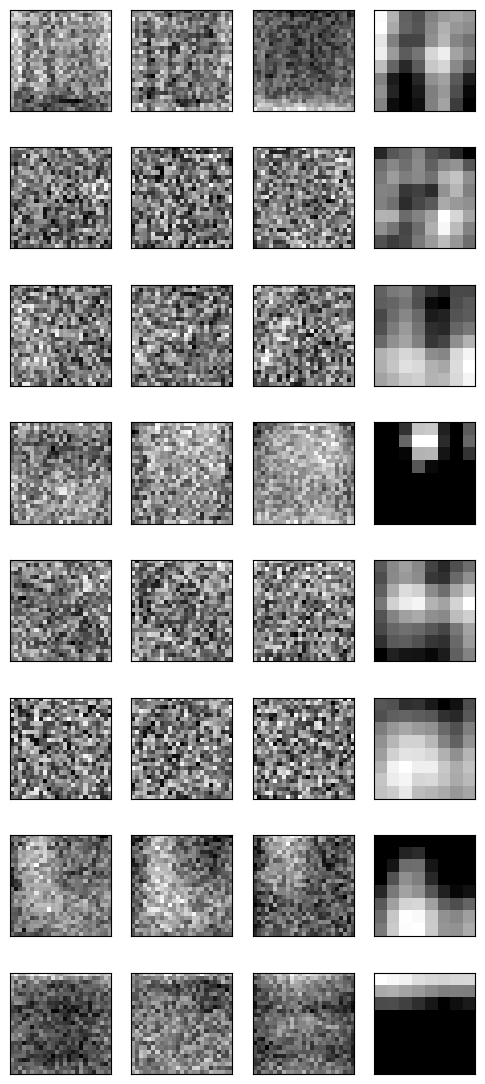

In [662]:
# get filters
filters = filters_k[9]

# get feature map for conv layer
feature_maps = conv_layer_k[9](img)

fig = plt.figure(figsize=(6, 14))
ix =  1

# display every other filter
for i in range(0,16,2):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(4):
        # subplot for 6 filters and 3 channels and activation map in grayscale
        # specify subplot and turn of axis
        ax = plt.subplot(8, 4, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        if j < 3:    
            # plot filter channel in grayscale
            plt.imshow(f[:, :, j], cmap='gray')
        else:
            # plot feature map in grayscale
            plt.imshow(feature_maps[0,:,:,i] , cmap='gray')

        ix += 1
# plot the filters
plt.show()

#### Visualize the learned filters and filtered test image for k = 30

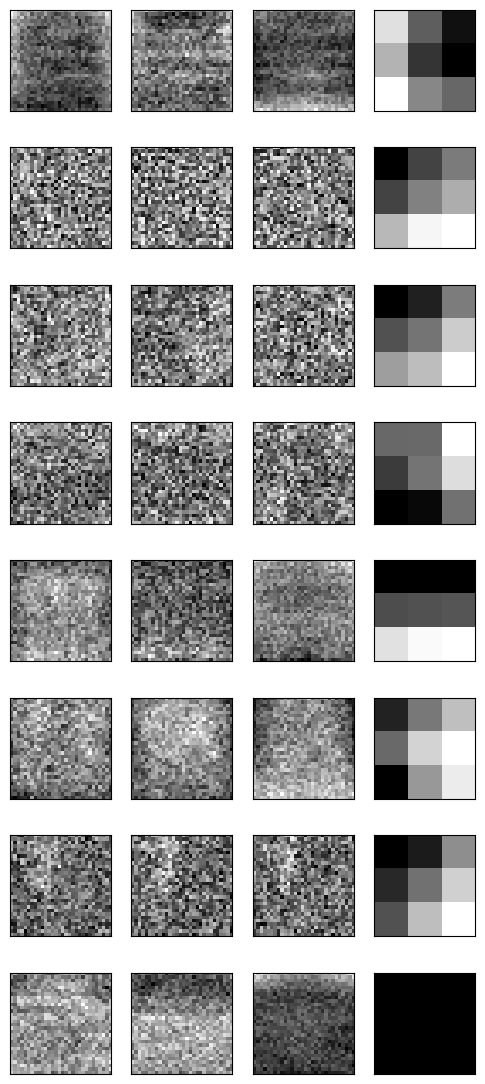

In [663]:
# get filters
filters = filters_k[-1]

# get feature map for conv layer
feature_maps = conv_layer_k[-1](img)

fig = plt.figure(figsize=(6, 14))
ix =  1

# display every other filter
for i in range(0,16,2):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(4):
        # subplot for 6 filters and 3 channels and activation map in grayscale
        # specify subplot and turn of axis
        ax = plt.subplot(8, 4, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        if j < 3:    
            # plot filter channel in grayscale
            plt.imshow(f[:, :, j], cmap='gray')
        else:
            # plot feature map in grayscale
            plt.imshow(feature_maps[0,:,:,i] , cmap='gray')

        ix += 1
# plot the filters
plt.show()

#### The smaller filters are able to learn local patterns such as edges and lines, while the larger filters are unable to do so.  `Since these local patterns are the most important features needed to classify the low-resolution images from our dataset, we conclude that the smaller size kernels result in higher classification accuracy on the test dataset`.